In [1]:
# import os
## Do not preallocate GPU memory
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = '\"platform\"'

from nodax import *
# jax.config.update("jax_debug_nans", True)




#%%


seed = 2026
# seed = int(np.random.randint(0, 10000))

context_pool_size = 2               ## Number of neighboring contexts j to use for a flow in env e
context_size = 256//2
nb_epochs = 1000
nb_epochs_adapt = 1000
init_lr = 1e-5

print_error_every = 100

train = True
run_folder = "./runs/24022024-161157/"      ## Run folder to use when not training

save_trainer = True

finetune = False

adapt = True
adapt_huge = False


activation = jax.nn.softplus
# activation = jax.nn.swish
# activation = lambda x:x
# activation = jax.nn.sigmoid


# integrator = diffrax.Dopri5
integrator = RK4
ivp_args = {"dt_init":1e-5, "rtol":1e-3, "atol":1e-6, "max_steps":4000, "subdivision":50}
## subdivision is used for non-adaptive integrators like RK4. It's the number of extra steps to take between each evaluation time point


############# Inductive Bias Learning for Dynamical Systems #############

Jax version: 0.4.23
Available devices: [cuda(id=0)]


In [2]:
if train == True:

    # check that 'tmp' folder exists. If not, create it
    if not os.path.exists('./runs'):
        os.mkdir('./runs')

    # Make a new folder inside 'tmp' whose name is the current time
    run_folder = './runs/'+time.strftime("%d%m%Y-%H%M%S")+'/'
    # run_folder = "./runs/23012024-163033/"
    os.mkdir(run_folder)
    print("Run folder created successfuly:", run_folder)

    # Save the run and dataset scripts in that folder
    script_name = os.path.basename(__file__)
    os.system(f"cp {script_name} {run_folder}")
    os.system(f"cp dataset.py {run_folder}")

    # Save the nodax module files as well
    os.system(f"cp -r ../../nodax {run_folder}")
    print("Completed copied scripts ")


else:
    # run_folder = "./runs/22022024-112457/"  ## Needed for loading the model and finetuning TODO: opti
    print("No training. Loading data and results from:", run_folder)

## Create a folder for the adaptation results
adapt_folder = run_folder+"adapt/"
if not os.path.exists(adapt_folder):
    os.mkdir(adapt_folder)

Run folder created successfuly: ./runs/25022024-125454/
Completed copied scripts 


In [3]:
if train == True:
    # Run the dataset script to generate the data
    os.system(f'python dataset.py --split=train --savepath="{run_folder}" --seed="{seed}"')
    os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}"')
if adapt == True:
    os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}"');
if adapt_huge == True:
    os.system(f'python dataset.py --split=adapt_huge --savepath="{adapt_folder}" --seed="{seed*4}"');


############# Inductive Bias Learning for Dynamical Systems #############

Jax version: 0.4.23
Available devices: [cuda(id=0)]
Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: train
 Savepath: ./runs/25022024-125454/
 Seed: 2026


############# Inductive Bias Learning for Dynamical Systems #############

Jax version: 0.4.23
Available devices: [cuda(id=0)]
Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: test
 Savepath: ./runs/25022024-125454/
 Seed: 4052


############# Inductive Bias Learning for Dynamical Systems #############

Jax version: 0.4.23
Available devices: [cuda(id=0)]
Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: adapt
 Savepath: ./runs/25022024-125454/adapt/
 Seed: 6078



In [4]:
## Define dataloader for training and validation
train_dataloader = DataLoader(run_folder+"train_data.npz", batch_size=-1, shuffle=True, key=seed)

nb_envs = train_dataloader.nb_envs
nb_trajs_per_env = train_dataloader.nb_trajs_per_env
nb_steps_per_traj = train_dataloader.nb_steps_per_traj
data_size = train_dataloader.data_size

val_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False)

In [5]:
## Define model and loss function for the learner


def circular_pad_2d(x, pad_width):
    """ Circular padding for 2D arrays """
    if isinstance(pad_width, int):
        pad_width = ((pad_width, pad_width), (pad_width, pad_width))
    # return jnp.pad(x, pad_width, mode='wrap')
    
    if x.ndim == 2:
        return jnp.pad(x, pad_width, mode='wrap')
    else:
        zero_pad = [(0,0)]*(x.ndim-2)
        return jnp.pad(x, zero_pad+list(pad_width), mode='wrap')
    # return jnp.pad(x, pad_width, mode='wrap')

class Augmentation(eqx.Module):
    layers_data: list
    layers_context: list
    layers_shared: list



    def __init__(self, data_res, kernel_size, nb_int_channels, context_size, key=None):

        chans = 2

        keys = generate_new_keys(key, num=12)
        circular_pad = lambda x: circular_pad_2d(x, kernel_size//2)

        self.layers_context = [eqx.nn.Linear(context_size, data_res*data_res*nb_int_channels, key=keys[3]), activation,
                                lambda x: jnp.stack(vec_to_mats(x, data_res, nb_int_channels), axis=0)]

        self.layers_data = [lambda x: jnp.stack(vec_to_mats(x, data_res, 2), axis=0)]
                            # circular_pad,
                            # eqx.nn.Conv2d(2, nb_int_channels, kernel_size, key=keys[0]), activation]

        self.layers_shared = [circular_pad, 
                              eqx.nn.Conv2d(nb_int_channels+2, chans, kernel_size, key=keys[6]), activation,
                              circular_pad, 
                            #   eqx.nn.Conv2d(chans, chans, kernel_size, key=keys[7]), activation,
                            #   circular_pad, 
                              eqx.nn.Conv2d(chans, chans, kernel_size, key=keys[8]), activation,
                              circular_pad, 
                              eqx.nn.Conv2d(chans, 2, kernel_size, key=keys[9]),
                              lambda x: x.flatten()]

    def __call__(self, t, y, ctx):
        # return jnp.zeros_like(y)*ctx[0]

        for layer in self.layers_context:
            ctx = layer(ctx)

        for layer in self.layers_data:
            y = layer(y)

        y = jnp.concatenate([y, ctx], axis=0)
        # y = jnp.concatenate([y, y], axis=0)
        for layer in self.layers_shared:
            y = layer(y)

        return y
        # return jnp.zeros_like(y)



def vec_to_mat(vec_uv, res=32):
    UV = jnp.split(vec_uv, 2)
    U = jnp.reshape(UV[0], (res, res))
    V = jnp.reshape(UV[1], (res, res))
    return U, V

def mat_to_vec(mat_U, mat_V, res):
    dudt = jnp.reshape(mat_U, res * res)
    dvdt = jnp.reshape(mat_V, res * res)
    return jnp.concatenate((dudt, dvdt))

def laplacian2D(a):
    # a_nn | a_nz | a_np
    # a_zn | a    | a_zp
    # a_pn | a_pz | a_pp
    a_zz = a

    a_nz = jnp.roll(a_zz, (+1, 0), (0, 1))
    a_pz = jnp.roll(a_zz, (-1, 0), (0, 1))
    a_zn = jnp.roll(a_zz, (0, +1), (0, 1))
    a_zp = jnp.roll(a_zz, (0, -1), (0, 1))

    a_nn = jnp.roll(a_zz, (+1, +1), (0, 1))
    a_np = jnp.roll(a_zz, (+1, -1), (0, 1))
    a_pn = jnp.roll(a_zz, (-1, +1), (0, 1))
    a_pp = jnp.roll(a_zz, (-1, -1), (0, 1))

    return (- 3 * a + 0.5 * (a_nz + a_pz + a_zn + a_zp) + 0.25 * (a_nn + a_np + a_pn + a_pp)) / (1. ** 2)

# class Physics(eqx.Module):
#     layers: list
#     # number: jnp.ndarray

#     def __init__(self, key=None):
#         keys = generate_new_keys(key, num=4)
#         width_size = 8
#         # # new_act = jax.nn.sigmoid
#         self.layers = [eqx.nn.Linear(context_size, width_size*2, key=keys[0]), activation,
#                         eqx.nn.Linear(width_size*2, width_size*2, key=keys[1]), activation,
#                         eqx.nn.Linear(width_size*2, width_size*2, key=keys[2]), activation,
#                         eqx.nn.Linear(width_size*2, 4, key=keys[3])]
#         # self.number = jax.random.uniform(keys[0], shape=(1,), minval=0.01, maxval=0.5)

#     def __call__(self, t, uv, ctx):
#         params = ctx
#         for layer in self.layers:
#             params = layer(params)
#         params = jnp.abs(params)
#         # params = jnp.array([0.2097, 0.105, 0.03, 0.062])
#         # params = jnp.array([0.2097, 0.105, 0.03, self.number[0]*ctx[0]])

#         U, V = vec_to_mat(uv, 32)
#         deltaU = laplacian2D(U)
#         deltaV = laplacian2D(V)
#         dUdt = (params[0] * deltaU - U * (V ** 2) + params[2] * (1. - U))
#         dVdt = (params[1] * deltaV + U * (V ** 2) - (params[2] + params[3]) * V)
#         duvdt = mat_to_vec(dUdt, dVdt, 32)

#         duvdt = jnp.nan_to_num(duvdt, nan=0.0, posinf=0.0, neginf=0.0)
#         return duvdt


# init_lr = 1e-6
circular_pad = lambda x: circular_pad_2d(x, 3//2)

class Physics(eqx.Module):
    layers: list
    # number: jnp.ndarray

    def __init__(self, key=None):
        keys = generate_new_keys(key, num=4)
        width_size = 8
        # # new_act = jax.nn.sigmoid
        self.layers = [eqx.nn.Conv2d(1, 1, 3, use_bias=False, key=keys[1]),
                        eqx.nn.Conv2d(1, 1, 3, use_bias=False, key=keys[2])]
        # self.number = jax.random.uniform(keys[0], shape=(1,), minval=0.01, maxval=0.5)

        true_kernel = jnp.array([[[[0.25, 0.5, 0.25], [0.5, -3., 0.5], [0.25, 0.5, 0.25]]]])
        # self.layers[0] = eqx.tree_at(lambda l:l.weight, self.layers[0], true_kernel)
        # self.layers[1] = eqx.tree_at(lambda l:l.weight, self.layers[1], true_kernel)

        # guess_kernel1 = jax.random.uniform(keys[0], shape=(1, 1, 3, 3), minval=-3, maxval=3)/20.
        # guess_kernel2 = jax.random.uniform(keys[1], shape=(1, 1, 3, 3), minval=-3, maxval=3)/10.
        guess_kernel1 = true_kernel + 1e-3*jax.random.normal(keys[0], shape=(1, 1, 3, 3))
        guess_kernel2 = true_kernel + 1e-3*jax.random.normal(keys[1], shape=(1, 1, 3, 3))
        self.layers[0] = eqx.tree_at(lambda l:l.weight, self.layers[0], guess_kernel1)
        self.layers[1] = eqx.tree_at(lambda l:l.weight, self.layers[1], guess_kernel2)


    def __call__(self, t, uv, ctx):
        # params = ctx
        # for layer in self.layers:
        #     params = layer(params)
        # params = jnp.abs(params)
        params = jnp.array([0.2097, 0.105, 0.03, 0.062])
        # params = jnp.array([0.2097, 0.105, 0.03, self.number[0]*ctx[0]])

        U, V = vec_to_mat(uv, 32)
        deltaU = self.layers[0](circular_pad(U[None,...]))[0,...]
        deltaV = self.layers[1](circular_pad(V[None,...]))[0,...]
        # deltaU = laplacian2D(U)
        # deltaV = laplacian2D(V)
        dUdt = (params[0] * deltaU - U * (V ** 2) + params[2] * (1. - U))
        dVdt = (params[1] * deltaV + U * (V ** 2) - (params[2] + params[3]) * V)
        duvdt = mat_to_vec(dUdt, dVdt, 32)

        # duvdt = jnp.nan_to_num(duvdt, nan=0.0, posinf=0.0, neginf=0.0)
        return duvdt




class ContextFlowVectorField(eqx.Module):
    physics: eqx.Module
    augmentation: eqx.Module

    def __init__(self, augmentation, physics=None):
        self.augmentation = augmentation
        self.physics = physics

    def __call__(self, t, x, ctxs):
        if self.physics is None:
            vf = lambda xi_: self.augmentation(t, x, xi_)
        else:
            # vf = lambda xi_: self.physics(t, x, xi_) + self.augmentation(t, x, xi_)
            vf = lambda xi_: self.physics(t, x, xi_)

        gradvf = lambda xi_, xi: eqx.filter_jvp(vf, (xi_,), (xi-xi_,))[1]

        ctx, ctx_ = ctxs
        # return vf(ctx_) + gradvf(ctx_, ctx)
        return vf(ctx)


augmentation = Augmentation(data_res=32, kernel_size=3, nb_int_channels=4, context_size=context_size, key=seed)

physics = Physics(key=seed)
# physics = None

vectorfield = ContextFlowVectorField(augmentation, physics=physics)
print("\n\nTotal number of parameters in the model:", sum(x.size for x in jax.tree_util.tree_leaves(eqx.filter(vectorfield,eqx.is_array)) if x is not None), "\n\n")

contexts = ContextParams(nb_envs, context_size, key=None)

## Define a custom loss function here
def loss_fn_ctx(model, trajs, t_eval, ctx, all_ctx_s, key):

    # ind = jax.random.randint(key, shape=(context_pool_size,), minval=0, maxval=all_ctx_s.shape[0])
    ind = jax.random.permutation(key, all_ctx_s.shape[0])[:context_pool_size]
    ctx_s = all_ctx_s[ind, :]

    # jax.debug.print("indices chosen for this loss {}", ind)

    trajs_hat, nb_steps = jax.vmap(model, in_axes=(None, None, None, 0))(trajs[:, 0, :], t_eval, ctx, ctx_s)
    new_trajs = jnp.broadcast_to(trajs, trajs_hat.shape)

    term1 = jnp.mean((new_trajs-trajs_hat)**2)  ## reconstruction
    term2 = jnp.mean(ctx**2)             ## regularisation

    # loss_val = term1 + 1e-3*term2
    # loss_val = jnp.nan_to_num(term1, nan=0.0, posinf=0.0, neginf=0.0)
    loss_val = term1

    return loss_val, (jnp.sum(nb_steps)/ctx_s.shape[0], term1, term2)




learner = Learner(vectorfield, contexts, loss_fn_ctx, integrator, ivp_args, key=seed)



Total number of parameters in the model: 528588 




In [6]:
## Define optimiser and traine the model

nb_total_epochs = nb_epochs * 1
sched_node = optax.piecewise_constant_schedule(init_value=init_lr,
                        boundaries_and_scales={nb_total_epochs//3:0.1, 2*nb_total_epochs//3:0.1})

sched_ctx = optax.piecewise_constant_schedule(init_value=init_lr,
                        boundaries_and_scales={nb_total_epochs//3:0.1, 2*nb_total_epochs//3:0.1})

opt_node = optax.adabelief(sched_node)
opt_ctx = optax.adabelief(sched_ctx)

trainer = Trainer(train_dataloader, learner, (opt_node, opt_ctx), key=seed)

In [7]:
trainer_save_path = run_folder if save_trainer == True else False
if train == True:
    # for propostion in [0.25, 0.5, 0.75]:
    for i, prop in enumerate(np.linspace(1.0, 1.0, 1)):
        # trainer.dataloader.int_cutoff = int(prop*nb_steps_per_traj)
        trainer.train(nb_epochs=nb_epochs*(2**0), print_error_every=print_error_every*(2**0), update_context_every=1, save_path=trainer_save_path, key=seed, val_dataloader=val_dataloader, int_prop=prop)

else:
    # print("\nNo training, attempting to load model and results from "+ run_folder +" folder ...\n")

    restore_folder = run_folder
    # restore_folder = "./runs/27012024-155719/finetune_193625/"
    trainer.restore_trainer(path=restore_folder)



=== Beginning training ... ===
    Number of examples in a batch: 1
    Number of train steps per epoch: 1
    Number of training epochs: 1000
    Total number of training steps: 1000

Compiling function "train_step" for neural ode ...
Shapes of elements in a batch: (1, 1, 10, 2048) (10,)

Compiling function "train_step" for context ...
Shapes of elements in a batch: (1, 1, 10, 2048) (10,)
    Epoch:     0      LossTrajs: 0.01274090     ContextsNorm: 0.00000000     ValIndCrit: 0.01204681
    Epoch:     1      LossTrajs: 0.01270065     ContextsNorm: 0.00000000     ValIndCrit: 0.01138160
    Epoch:     2      LossTrajs: 0.01265824     ContextsNorm: 0.00000000     ValIndCrit: 0.01112446
    Epoch:     3      LossTrajs: 0.01261354     ContextsNorm: 0.00000000     ValIndCrit: 0.01014488
    Epoch:   100      LossTrajs: 0.00010823     ContextsNorm: 0.00000000     ValIndCrit: 0.00038103
    Epoch:   200      LossTrajs: 0.00001930     ContextsNorm: 0.00000000     ValIndCrit: 0.00005106
    E

In [8]:
if finetune:
    # ## Finetune a trained model

    finetunedir = run_folder+"finetune_"+trainer.dataloader.data_id+"/"
    if not os.path.exists(finetunedir):
        os.mkdir(finetunedir)
    print("No training. Loading anctx_sd finetuning into:", finetunedir)

    trainer.dataloader.int_cutoff = nb_steps_per_traj

    opt_node = optax.adabelief(1e-7)
    opt_ctx = optax.adabelief(1e-7)
    trainer.opt_node, trainer.opt_ctx = opt_node, opt_ctx

    # trainer.opt_node_state = trainer.opt_node.init(eqx.filter(trainer.learner.neuralode, eqx.is_array))
    # trainer.opt_ctx_state = trainer.opt_ctx.init(trainer.learner.contexts)

    trainer.train(nb_epochs=24000, print_error_every=1000, update_context_every=1, save_path=finetunedir, key=seed)

==  Begining in-domain testing ... ==
    Number of training environments: 1
    Final length of the training trajectories: 10
    Length of the testing trajectories: 10
Test Score (In-Domain): 2.059682e-05

==  Begining in-domain visualisation ... ==
    Environment id: 0
    Trajectory id: 13
    Visualized dimensions: (0, 1)
    Final length of the training trajectories: 10
    Length of the testing trajectories: 10
Testing finished. Figure saved in: ./runs/25022024-125454/results_in_domain.png


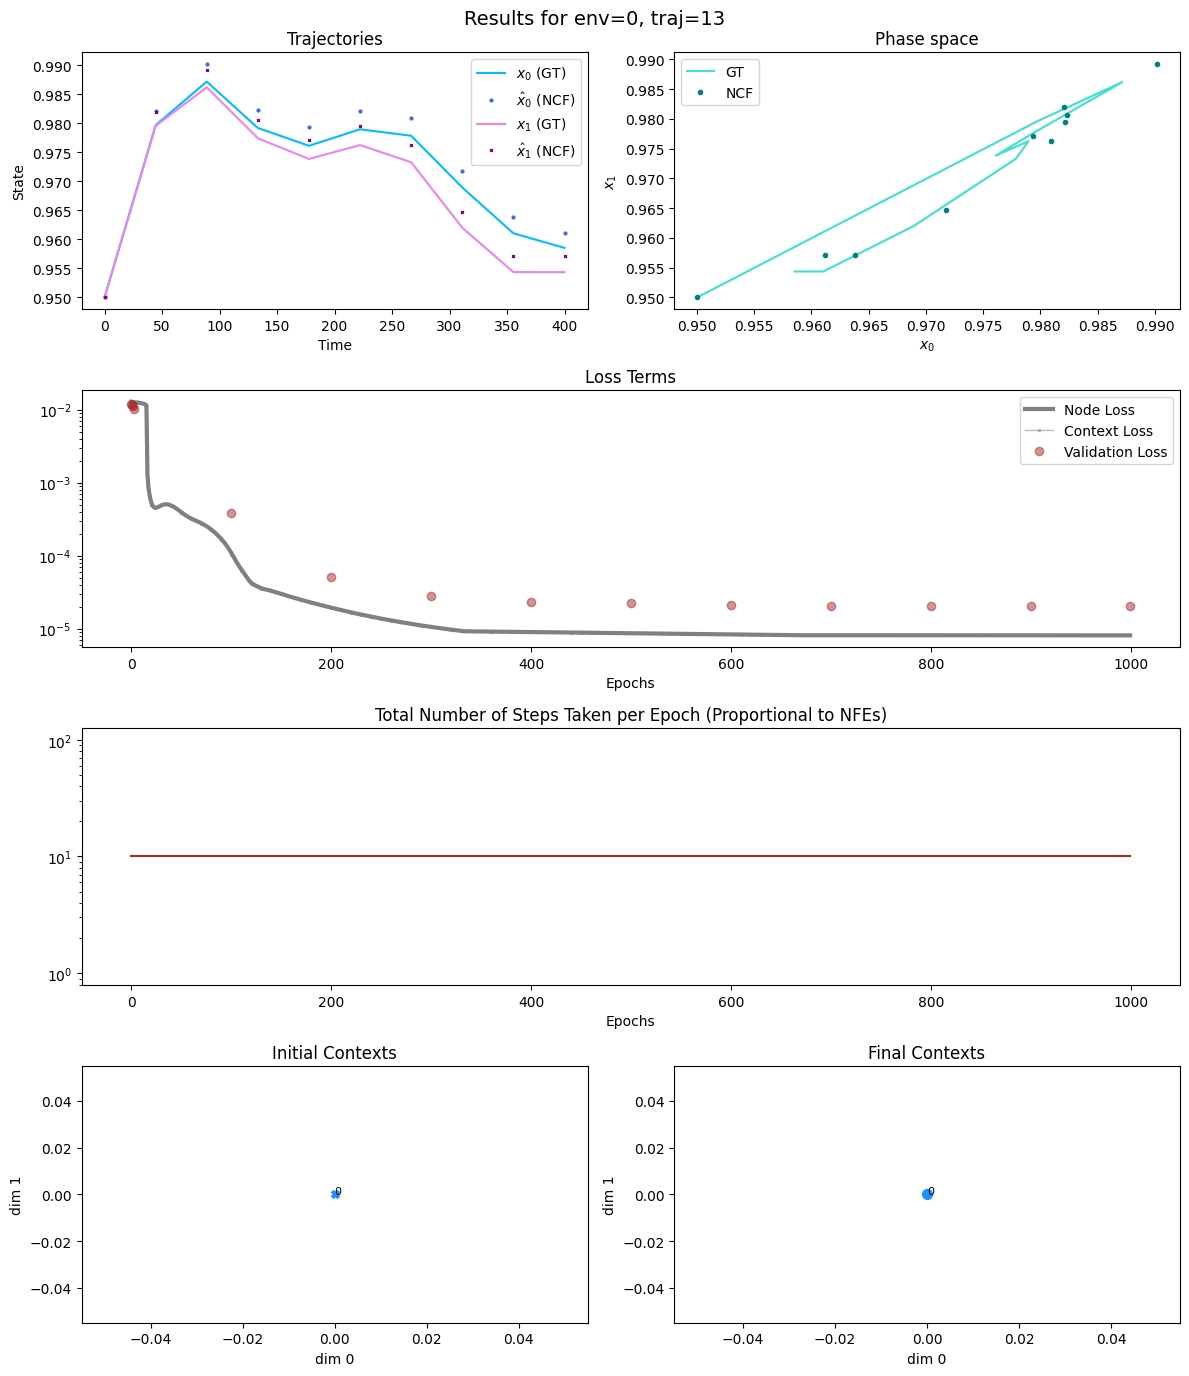

In [9]:
## Test and visualise the results on a test dataloader

test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False)
visualtester = VisualTester(trainer)
# ans = visualtester.trainer.nb_steps_node
# print(ans.shape)

ind_crit = visualtester.test(test_dataloader, int_cutoff=1.0)

if finetune:
    savefigdir = finetunedir+"results_in_domain.png"
else:
    savefigdir = run_folder+"results_in_domain.png"
visualtester.visualize(test_dataloader, int_cutoff=1.0, save_path=savefigdir);

==  Begining in-domain 2D visualisation ... ==
    Environment id: 0
    Trajectory id: 3
    Length of the testing trajectories: 10
Testing finished. Figure saved in: ./runs/25022024-125454/results_2D_ind.png


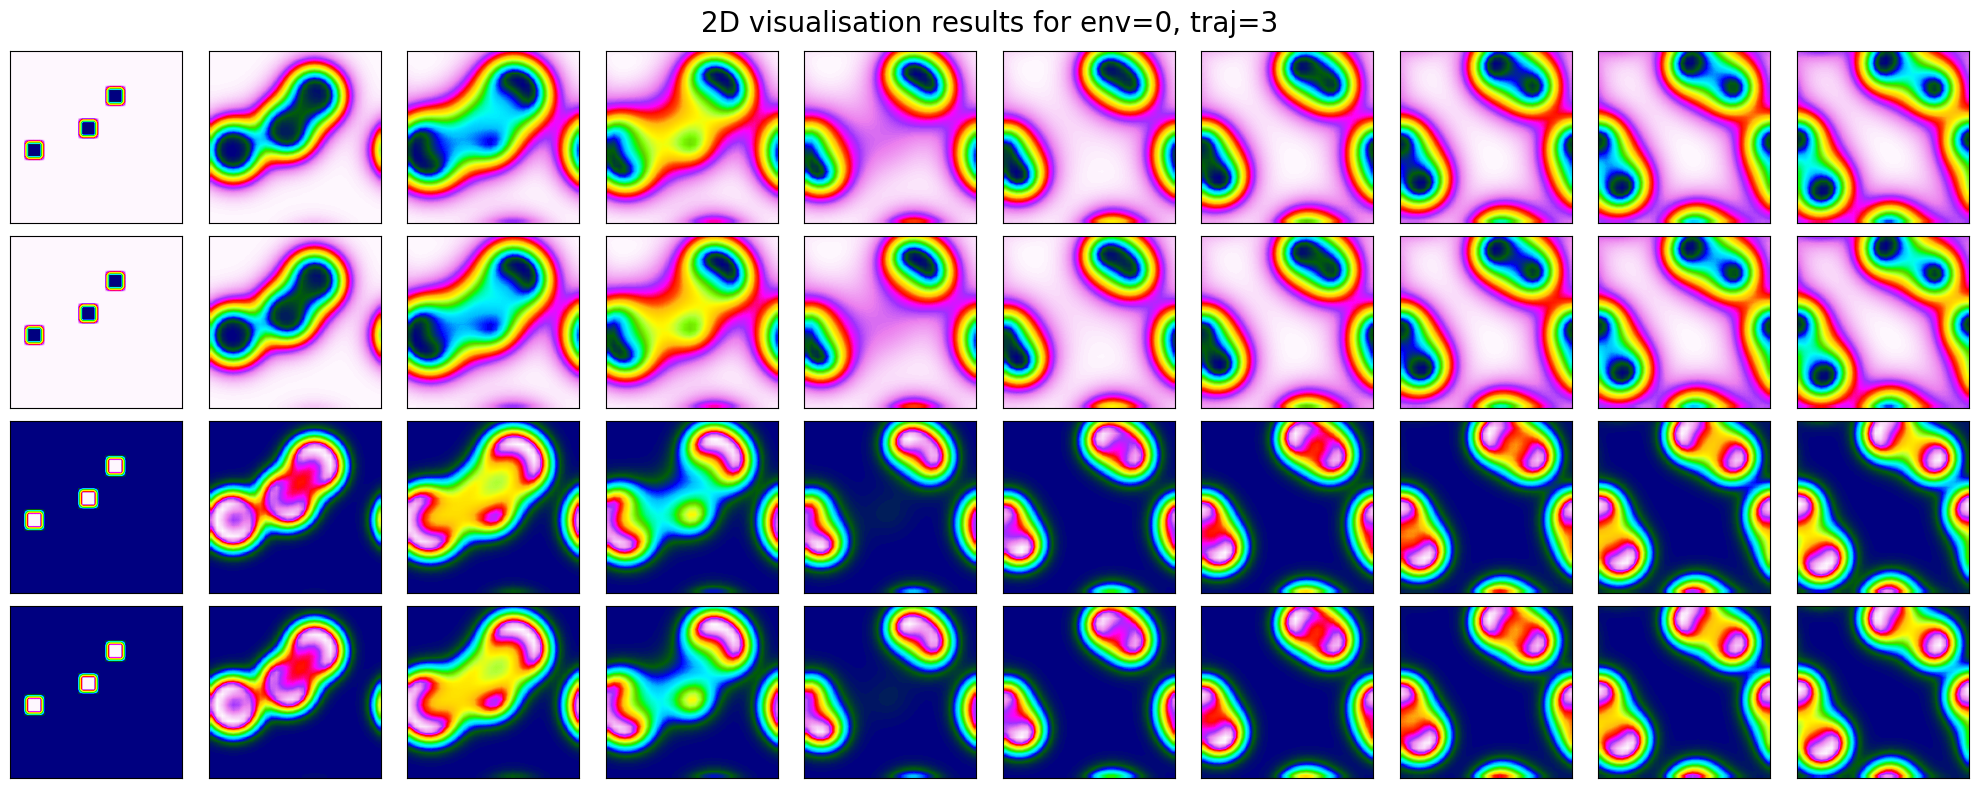

In [10]:
## Custom Gray-Scott trajectory visualiser
if finetune:
    savefigdir = finetunedir+"results_2D_ind.png"
else:
    savefigdir = run_folder+"results_2D_ind.png"
visualtester.visualize2D(test_dataloader, int_cutoff=1.0, res=32, save_path=savefigdir);

In [11]:
# len(trainer.losses_node

# ## Run and get the contexts
# for i in range(nb_envs):
#     ctx = trainer.learner.contexts.params[i]
#     # print(ctx)
#     param = ctx
#     for layer in trainer.learner.physics.layers_context:
#         param = layer(param)
#         # print("Context", ctx, "     Param", param)
#     param = jnp.abs(param)
#     print("Param:", param)

In [12]:
## Give the dataloader an id to help with restoration later on

adapt_dataloader = DataLoader(adapt_folder+"adapt_data.npz", adaptation=True, data_id="170846", key=seed)

# sched_ctx_new = optax.piecewise_constant_schedule(init_value=1e-5,
#                         boundaries_and_scales={int(nb_epochs_adapt*0.25):1.,
#                                                 int(nb_epochs_adapt*0.5):0.1,
#                                                 int(nb_epochs_adapt*0.75):1.})
sched_ctx_new = optax.piecewise_constant_schedule(init_value=init_lr,
                        boundaries_and_scales={nb_total_epochs//3:0.1, 2*nb_total_epochs//3:1.0})
# sched_ctx_new = 1e-5
opt_adapt = optax.adabelief(sched_ctx_new)

if adapt == True:
    trainer.adapt(adapt_dataloader, nb_epochs=nb_epochs_adapt, optimizer=opt_adapt, print_error_every=print_error_every, save_path=adapt_folder)
else:
    print("save_id:", adapt_dataloader.data_id)

    trainer.restore_adapted_trainer(path=adapt_folder, data_loader=adapt_dataloader)



=== Beginning adaptation ... ===
    Number of examples in a batch: 1
    Number of train steps per epoch: 1
    Number of training epochs: 1000
    Total number of training steps: 1000

Compiling function "train_step" for context ...
Shapes of elements in a batch: (4, 1, 10, 2048) (10,)
    Epoch:     0     LossContext: 0.02248150
    Epoch:     1     LossContext: 0.02248150
    Epoch:     2     LossContext: 0.02248150
    Epoch:     3     LossContext: 0.02248150
    Epoch:   100     LossContext: 0.02248150
    Epoch:   200     LossContext: 0.02248150
    Epoch:   300     LossContext: 0.02248150
    Epoch:   400     LossContext: 0.02248150
    Epoch:   500     LossContext: 0.02248150
    Epoch:   600     LossContext: 0.02248150
    Epoch:   700     LossContext: 0.02248150
    Epoch:   800     LossContext: 0.02248150
    Epoch:   900     LossContext: 0.02248150
    Epoch:   999     LossContext: 0.02248150

Total gradient descent adaptation time: 0 hours 0 mins 23 secs
Environment wei

==  Begining out-of-distribution testing ... ==
    Number of training environments: 1
    Number of adaptation environments: 4
    Final length of the training trajectories: 10
    Length of the testing trajectories: 10
Test Score (OOD): 0.022481505

==  Begining out-of-distribution visualisation ... ==
    Environment id: 3
    Trajectory id: 0
    Visualized dimensions: (0, 1)
    Final length of the training trajectories: 10
    Length of the testing trajectories: 10
Testing finished. Figure saved in: ./runs/25022024-125454/adapt/results_ood.png


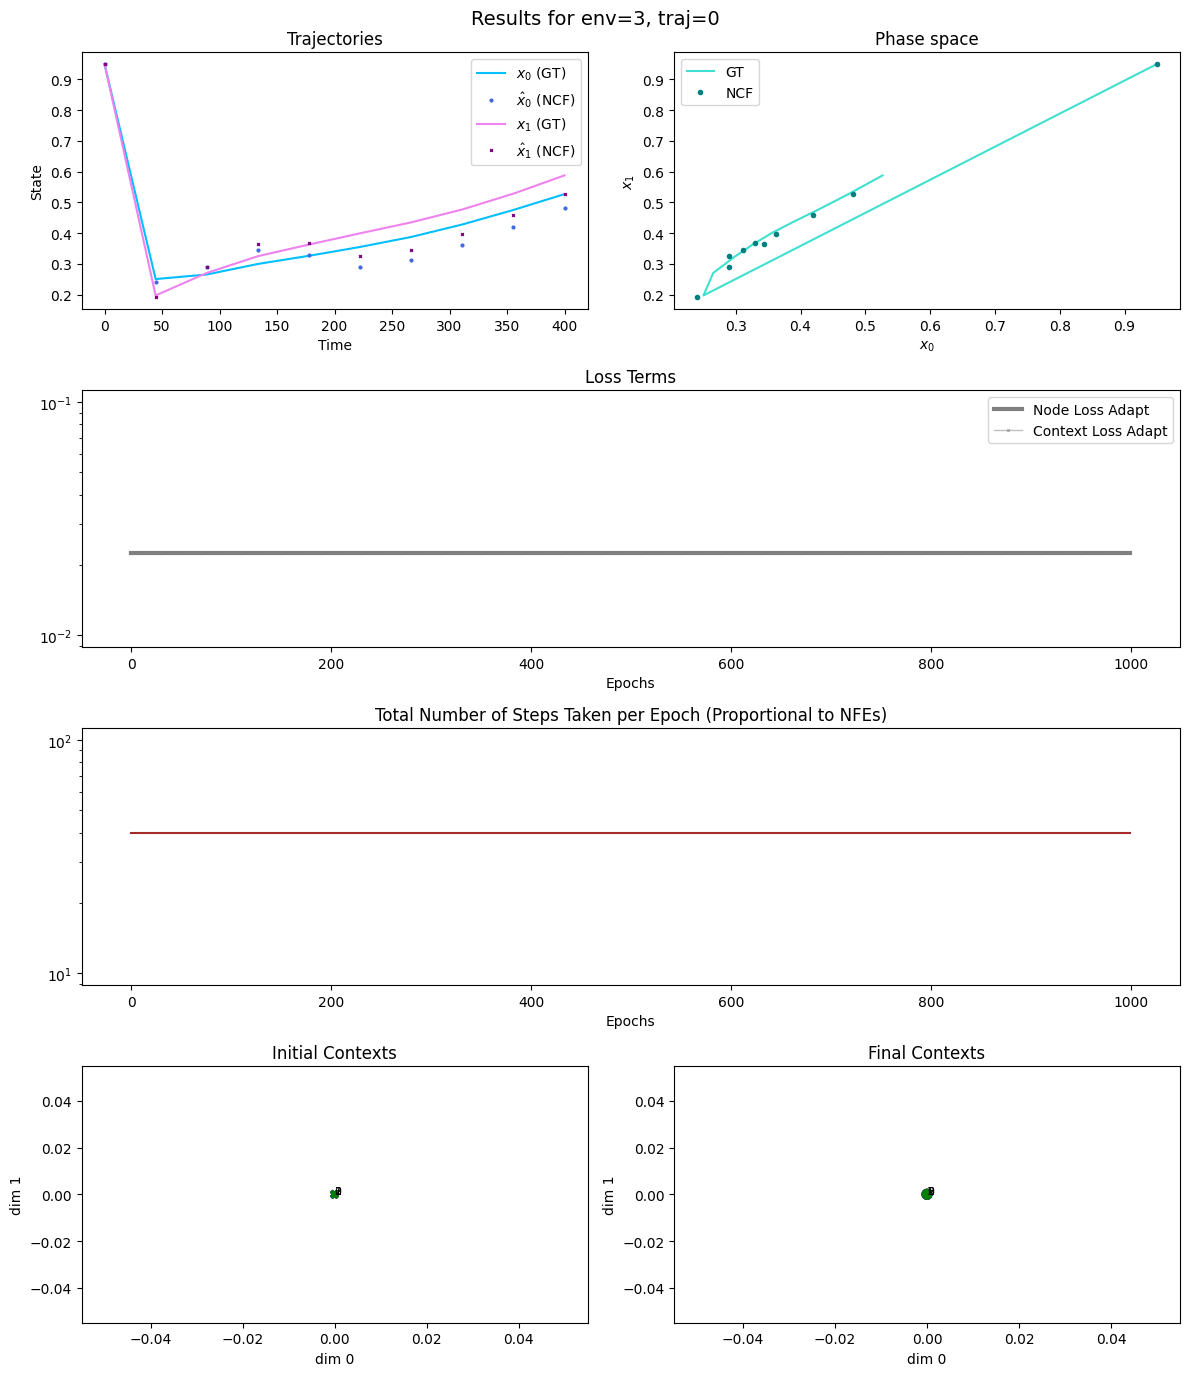

In [13]:
ood_crit = visualtester.test(adapt_dataloader, int_cutoff=1.0)      ## It's the same visualtester as before during training. It knows trainer

visualtester.visualize(adapt_dataloader, int_cutoff=1.0, save_path=adapt_folder+"results_ood.png");

In [14]:
## If the nohup.log file exists, copy it to the run folder
try:
    __IPYTHON__ ## in a jupyter notebook
except NameError:
    if os.path.exists("nohup.log"):
        if finetune == True:
            os.system(f"cp nohup.log {finetunedir}")
            ## Open the results_in_domain in the terminal
            os.system(f"open {finetunedir}results_in_domain.png")
        else:
            os.system(f"cp nohup.log {run_folder}")
            os.system(f"open {run_folder}results_in_domain.png")

In [15]:
# eqx.tree_deserialise_leaves(run_folder+"contexts.eqx", learner.contexts)

In [16]:
#### Generate data for analysis


# ## We want to store 3 values in a CSV file: "seed", "ind_crit", and "ood_crit", into the test_scores.csv file


# print("\nFull evaluation of the model on 10 random seeds\n", flush=True)

# # First, check if the file exists. If not, create it and write the header
# if not os.path.exists(run_folder+'analysis'):
#     os.mkdir(run_folder+'analysis')

# csv_file = run_folder+'analysis/test_scores.csv'
# if not os.path.exists(csv_file):
#     os.system(f"touch {csv_file}")

# with open(csv_file, 'r') as f:
#     lines = f.readlines()
#     if len(lines) == 0:
#         with open(csv_file, 'w') as f:
#             f.write("seed,ind_crit,ood_crit\n")


# ## Get results on test and adaptation datasets, then append them to the csv

# np.random.seed(seed)
# seeds = np.random.randint(0, 10000, 10)
# for seed in seeds:
# # for seed in range(8000, 6*10**3, 10):
#     os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}" --verbose=0')
#     os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}" --verbose=0')

#     test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False, batch_size=1, data_id="082026")
#     adapt_test_dataloader = DataLoader(adapt_folder+"adapt_data.npz", adaptation=True, batch_size=1, key=seed, data_id="082026")

#     ind_crit, _ = visualtester.test(test_dataloader, int_cutoff=1.0, verbose=False)
#     ood_crit, _ = visualtester.test(adapt_test_dataloader, int_cutoff=1.0, verbose=False)

#     with open(csv_file, 'a') as f:
#         f.write(f"{seed},{ind_crit},{ood_crit}\n")


# ## Print the mean and stds of the scores
# import pandas as pd
# pd.set_option('display.float_format', '{:.2e}'.format)
# test_scores = pd.read_csv(csv_file).describe()
# print(test_scores.iloc[:3])